Most of the DSP code is taken from https://pysdr.org

In [1]:
import adi
import numpy as np
import matplotlib.pyplot as plt

In [2]:
fs = 5e6
fc = 150e6
num_samps = 65536

In [3]:
fsym = 150e6/256 # 256x divider
sps = fs/fsym

In [4]:
sdr = adi.Pluto('ip:192.168.20.1')
# sdr.gain_control_mode_chan0 = "manual"
sdr.sample_rate = int(fs)
sdr.rx_lo = int(fc)
sdr.rx_hardwaregain_chan0 = 45 # dB
sdr.rx_rf_bandwidth = int(fs)
sdr.rx_buffer_size = num_samps

In [5]:
sdr.rx_destroy_buffer()

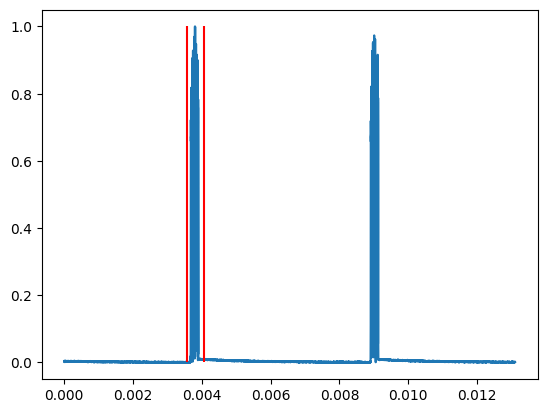

In [6]:
samples = sdr.rx()

# Pulse shaping
num_taps = 101
beta = 0.35
Ts = sps # Assume sample rate is 1 Hz, so sample period is 1, so *symbol* period is 8
t = np.arange(num_taps) - int(num_taps/2)
h = np.sinc(t/Ts) * np.cos(np.pi*beta*t/Ts) / (1 - (2*beta*t/Ts)**2)

samples = np.convolve(samples, h, mode="same")
samples = samples / np.max(np.abs(samples))

# Packet detection
# TODO: better message detection
# estimated message len, parse length later
message_len_ms = 0.5

t = np.arange(num_samps)/fs
plt.plot(t, np.abs(samples))
threshold = np.median(np.abs(samples)) * 5

start = np.argwhere(np.abs(samples) > threshold)[0][0]
start = start - 500
end = start + int(fs*message_len_ms/1000)
message = samples[start:end]
plt.vlines(t[[start, end]], 0, 1, 'r')

t = np.arange(len(message))/fs

In [7]:
# Coarse frequency sync
X = np.fft.fftshift(np.fft.fft(samples**2))
f = np.linspace(-fs/2, fs/2, len(X))
idx = np.argmax(np.abs(X))
f_offset = f[idx]

print(f_offset)

t = np.arange(0, len(message))/fs
message = message * np.exp(-1j*2*np.pi*f_offset*t/2.0)

4081.788357366342


In [8]:
# Time sync

samples = message
samples = samples / np.max(np.abs(samples))

mu = 0 # initial estimate of phase of sample
out = np.zeros(len(samples) + 10, dtype=np.complex64)
out_rail = np.zeros(len(samples) + 10, dtype=np.complex64) # stores values, each iteration we need the previous 2 values plus current value
i_in = 0 # input samples index
i_out = 2 # output index (let first two outputs be 0)
while i_out < len(samples) and i_in+16 < len(samples):
    out[i_out] = samples[i_in + int(mu)] # grab what we think is the "best" sample
    out_rail[i_out] = int(np.real(out[i_out]) > 0) + 1j*int(np.imag(out[i_out]) > 0)
    x = (out_rail[i_out] - out_rail[i_out-2]) * np.conj(out[i_out-1])
    y = (out[i_out] - out[i_out-2]) * np.conj(out_rail[i_out-1])
    mm_val = np.real(y - x)
    mu += sps + 0.3*mm_val
    i_in += int(np.floor(mu)) # round down to nearest int since we are using it as an index
    mu = mu - np.floor(mu) # remove the integer part of mu
    i_out += 1 # increment output index
out = out[2:i_out] # remove the first two, and anything after i_out (that was never filled out)

samples = out

In [9]:
# Fine frequency sync

N = len(samples)
phase = 0
freq = 0

# Loop params - https://www.trondeau.com/blog/2011/8/13/control-loop-gain-values.html
damp = np.sqrt(2)/2 # damping ratio, critically damped
bw = 0.2 # 0.05 default
alpha = (4 * damp * bw) / (1 + 2 * damp * bw + bw * bw)
beta = (4 * bw * bw) / (1 + 2 * damp * bw + bw * bw)

out = np.zeros(N, dtype=np.complex64)
freq_log = []
for i in range(N):
    out[i] = samples[i] * np.exp(-1j*phase) # adjust the input sample by the inverse of the estimated phase offset
    error = np.real(out[i]) * np.imag(out[i]) # This is the error formula for 2nd order Costas Loop (e.g. for BPSK)

    # Advance the loop (recalc phase and freq offset)
    freq += (beta * error)
    freq_log.append(freq * fs / (2*np.pi)) # convert from angular velocity to Hz for logging
    phase += freq + (alpha * error)

    # Optional: Adjust phase so its always between 0 and 2pi, recall that phase wraps around every 2pi
    while phase >= 2*np.pi:
        phase -= 2*np.pi
    while phase < 0:
        phase += 2*np.pi

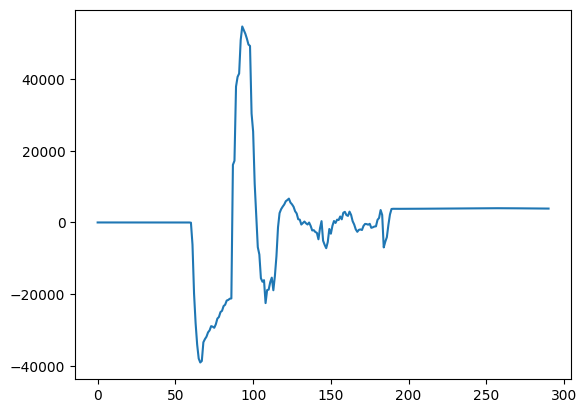

In [10]:
plt.plot(freq_log)

In [11]:
bits = [1 if x > 0 else 0 for x in out.real]
bits = "".join([str(x) for x in bits])

In [12]:
sync = [0x6B, 0xBE]
sync = "".join([f"{x:08b}"[::-1] for x in sync])

In [13]:
data = [int(x) for x in bits]
data = np.array(data)

decoded = data[1:] ^ data[:-1]
data = "".join([str(x) for x in decoded])

start = data.find(sync) + 16
end = len(data) - (len(data) - start) % 8
data = data[start:end]
data = [data[i:i+8][::-1] for i in range(0, len(data), 8)]
bytes([int(x, 2) for x in data])

b'hello there\xfc\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'